In [1]:
import warnings
warnings.filterwarnings("ignore")

# Local Spatial Autocorrelation

In the previous chapter, we explored how to use global measures of spatial autocorrelation to determine whether the overall spatial distribution of our attribute of interest was reflective of a geographically random process. These statistics are useful: the presence of spatial autocorrelation has important implications for subsequent statistical analysis. From a substantive perspective, spatial autocorrelation could reflect the operation of processes that generate association between the values in nearby locations. This could represent *spillovers*, where outcomes at one site influence other sites, or could indicate *contagion*, where outcomes at one site *causally influence* other sites. In these cases formal modeling of the spatial dimensions of the processes should next be carried out. On the other hand, spatial autocorrelation can sometimes arise from data processing operations in which cases the dependence is a form of non-random noise rather than due to substantive processes. For example, when "down-sampling" geographic data, sometimes large patches of identical values can be created. These may only be artifacts of the interpolation, rather than substantive autocorrelation. Regardless of whether the spatial autocorrelation is due to substantive or nuisance sources, it is a form of non-randomness that complicates statistical analysis.

For these reasons, the ability to determine whether spatial autocorrelation is present in a geographically referenced data set is a critical component of the geographic data science toolbox. That said, the global measures of spatial autocorrelation are "whole map" statistics, meaning that the single statistic pertains to the complete data set. For example,
Moran's $I$ is good tool to summarize a dataset into a single value that measures the degree of geographical clustering (or dispersion, if negative). However, Moran's $I$ is does not indicate areas within the map where specific types of values (e.g.
high, low) are located. 
In other words, Moran's I can tell us whether values in our map *cluster* together (or disperse) overall, but it will not inform us about where specific *clusters* (or outliers) are.

For that purpose, we need to use a local measure of spatial autocorrelation.
Local measures of spatial autocorrelation focus on the relationships between each observation and its surroundings, rather than providing a single-number summary of these relationships across the map. Because of that, they do not summarize the map overall, but they allow to obtain further insights about interesting geographical subsets of the data. In this chapter, we consider
Local Indicators of Spatial Association (LISAs) {cite}`Anselin1995local`, a local counter-part of global measures like Moran's I.



## An empirical illustration: the EU Referendum

We continue with the same dataset about Brexit voting that we examined in the previous chapter, and thus we utilize the same imports and initial data preparation steps:

In [2]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn                   # Graphics
import geopandas                 # Spatial data manipulation
import pandas                    # Tabular data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
import contextily                # Background tiles

In [3]:
ref = pandas.read_csv('../data/brexit/brexit_vote.csv', 
                      index_col='Area_Code')

Now let us bring in the spatial data:

In [4]:
lads = geopandas.read_file("../data/brexit/local_authority_districts.geojson")\
                .set_index('lad16cd')

Then, we need to "trim" the `DataFrame` so it only retains what we know we will need:

In [5]:
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


Although there are several variables that could be considered, we will focus on `Pct_Leave`, which measures the proportion of votes in the UK Local Authority that wanted to Leave the European Union. For convenience, let us merge this with the spatial data and project the output into the Spherical Mercator coordinate reference system (CRS), which will allow us to combine them with contextual tiles.

In [6]:
lads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

And with these elements, we can generate a choropleth to get a quick sense of the spatial distribution of the data we will be analyzing. Note how we use some visual tweaks (e.g., transparency through the `alpha` attribute) to make the final plot easier to read.

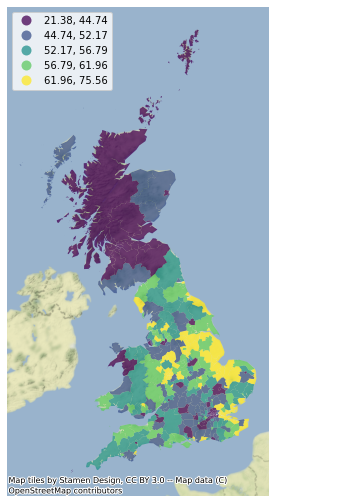

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='Pct_Leave', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )
ax.set_axis_off()

The final piece we need before we can delve into spatial autocorrelation is the spatial weights matrix that records which observations are "near" one another. We will use eight nearest neighbors for the sake of comparison with the previous chapter. And, we will also row-standardize the weights, so that *spatial lags* reflect the average of the eight nearest neighbors. 

In [8]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

## Motivating Local Spatial Autocorrelation

To better understand the underpinning of local autocorrelation, we will return to the Moran Plot as a graphical tool. Let us first calculate the spatial lag of our variable of interest:

In [9]:
db['w_Pct_Leave'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

And their respective standardized versions, where we subtract the average and divide by the standard deviation:

In [10]:
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()
db['w_Pct_Leave_std'] = ( db['w_Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python:

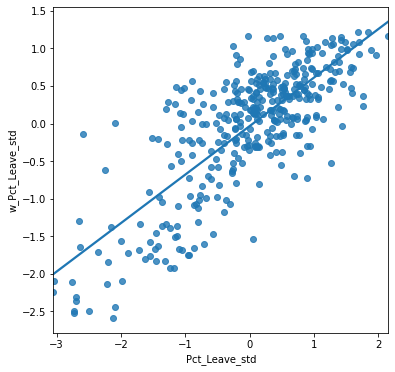

In [11]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Display
plt.show()

Using standardized values, we can immediately divide each variable (the percentage that voted to leave, and its spatial lag) in two groups. Those with above-average leave voting have positive standardized values, and those with below-average leave voting have negative standardized values. This, in turn, divides a Moran Plot in four quadrants, depending on whether a given area displays a value above the mean (high) or below (low) in either the original variable (`Pct_Leave`) or its spatial lag (`w_Pct_Leave_std`). 

* High-high (HH)
* Low-high (LH)
* Low-low (LL)
* High-low (HL)

Graphically, this can be captured as follows:

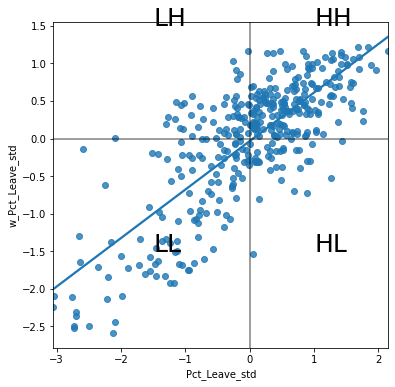

In [12]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

## Local Moran's $I_i$

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations represents a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high.

This is exactly what LISAs are designed to do. A more detailed description of their statistical underpinnings is beyond the scope in this context, but we will provide some intuition about how they work in one LISA statistic, the Local Moran's $I_i$. 

The core idea of a local Moran's $I_i$ is to identify cases in which the value of an observation and the average of its surroundings is either more similar (HH or LL in the scatterplot above) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation. This results in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.

LISAs are widely used in many fields to identify geographical clusters of values or find geographcial outliers. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. For that, they have a prime place in the geographic data science toolbox. Among many other applications, LISAs have been used to identify geographical clusters of poverty {cite}`Dawson2018`, map ethnic enclaves {cite}`Johnston2010EPA`, delineate areas of particularly high/low economic activity {cite}`Torres2014`, or identify clusters of contagious disease {cite}`zhang2020`. The Local Moran's $I_i$ statistic is only one of a wide variety of LISAs that can be used on many different types of spatial data.

In Python, we can calculate LISAs in a very streamlined way thanks to `PySAL`. To compute local Moran statistics, we use the `Moran_Local` function:

In [13]:
lisa = esda.moran.Moran_Local(db['Pct_Leave'], w)

We need to pass the variable of interest—proportion of Leave votes in this context—and the spatial weights that describes the neighborhood relations between the different areas that make up the dataset. This creates a LISA object (`lisa`) that has a number of attributes of interest. The local indicators themselves are in the `Is` attribute and we can get a sense of their distribution using `seaborn`:

<AxesSubplot:ylabel='Density'>

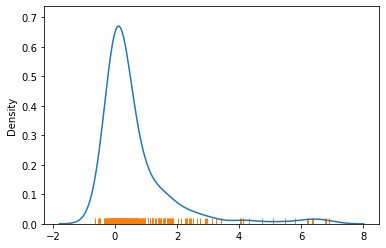

In [14]:
ax = seaborn.kdeplot(lisa.Is)
seaborn.rugplot(lisa.Is, ax=ax)

This reveals a rather skewed distribution of local Moran's $I_i$ statistics. This is due to the dominance of the positive forms of spatial association which means that most of the local values will usually be positive. Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values *or* low values next to low values. The local $I_i$ values alone cannot distinguish between these two.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the  $I_i$ value cannot distinguish between the two cases.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. In this context, a choropleth can help. At first glance, this may seem to suggest that a map of the $I_i$  values would be a useful way to visualize the spatial distribution:

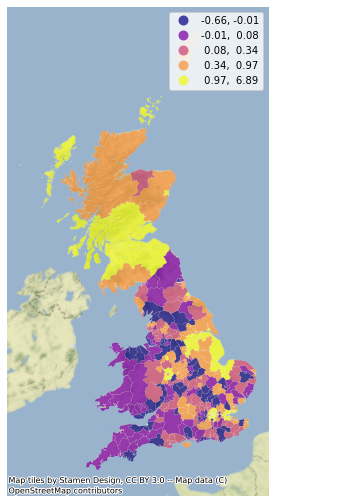

In [15]:
f, ax = plt.subplots(1, figsize=(9,9))
db['Is'] = lisa.Is
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

While this tells us whether the local association is positive (HH/LL) or negative (HL/LH), it cannot tell, for example, whether the yellow areas in Scotland are similar to those in the East cluster of yellow. Are the two experiencing similar patterns of sptaial association, or is one of them HH and the other LL?

Also, we know that values around zero will not be statistically significant. Which local statistics are thus significant and which non-significant from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones noise? To answer these questions, we need to bring in additional information that we have obtained when calculating the LISA statistics. 

Let us first build a four-plot figure that brings all these different perspectives together:

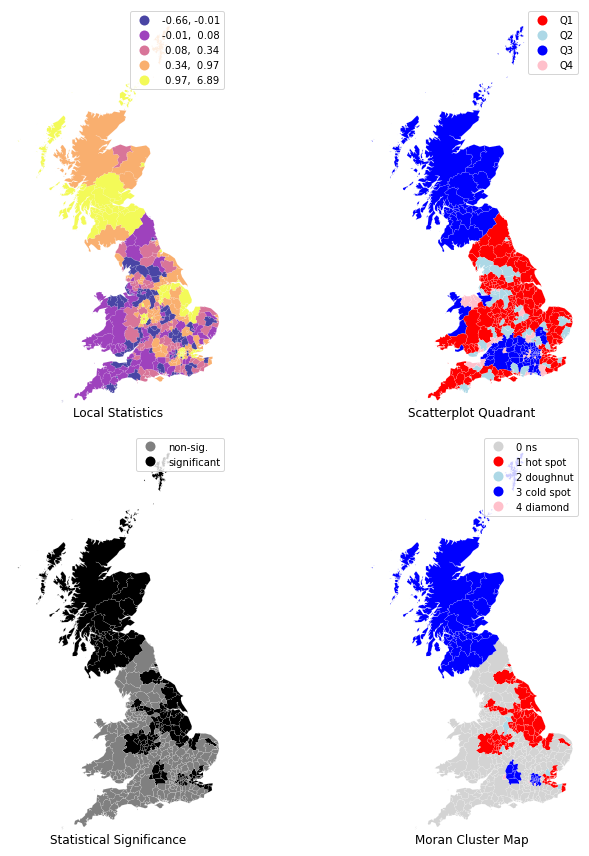

In [16]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])


db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Moran Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

The figure in the upper-left replicates our first map above. The purple and yellow locations have the largest values for the local statistics, yet this does not distinguish between positive association of low support for the Brexit vote and positive association of high support for Brexit.

To distinguish between these two cases, the map in the upper-right shows the location of the LISA statistic in the quadrant of the Moran Scatter plot. This indicates whether the positive (or negative) local association exists within a specific *quadrant*, such as the High-High quadrant. This information is recorded in the `q` attribute of the `lisa` object:

In [17]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1])

The correspondence between the numbers in the `q` attribute and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL



Comparing the two maps in the top row reveals that the positive local association in Scotland is due to low support for Brexit, while the positive local association in the south is among local authorities that strongly support Brexit. Overall, we can obtain counts of areas in each quadrant:

In [18]:
counts = pandas.value_counts(lisa.q)
counts

1    183
3    113
2     50
4     34
dtype: int64

Showing that the high-high (1), and low-low (3), values are predominant.

Care must be taken, however, in the interpretation of these first two maps, as the underlying statistical significance of the local values has not been considered. We have simply mapped the raw LISA value alongside the quadrant in which the local statistic resides. The statistical significance, mapped in the bottom left map, suggests that quite a few local authorities have local statistics that are small enough to have arisen by chance. 

Therefore, in order to focus on the local statistics that matter, we need to include the significance information alongside the quadrant and local statistic. Together, this "cluster map" (as it is usually called) extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object we have created above. But, to make the map making more straightforward, it is convenient to pull them out and insert them in the main data table:

In [19]:
sig = 1 * (lisa.p_sim < 0.05)
db['p-sim'] = lisa.p_sim
db['sig'] = sig
db[['sig','p-sim']].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.011
E06000002,1,0.008
E06000003,1,0.011
E06000004,1,0.011
E06000010,1,0.014


In [20]:
db[['sig','p-sim']].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.461
W06000019,0,0.449
W06000021,0,0.443
W06000022,0,0.407
W06000023,0,0.260


Thus, the first five values are statistically significant, while the last five observations are not.

Let us stop for a second on these two steps. First, we consider the `significant` column. Akin to global Moran's I, `PySAL` automatically computes a p-value for each LISA. Because some LISA statistics may not be statistically significant, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar local statistic in random maps. A few different ways of generating random maps are considered by `PySAL`, but we focus on a strategy that actually simulates hundreds of thousands of random maps to get a rough idea of the possible local statistic values at each local authority given the data we saw. 

In addition, we follow a similar reasoning as with global Moran's I and use 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation satisfies the condition, and `False` otherwise.

Next, we construct our quadrant values using the `q` attribute which records the Moran Scatterplot quadrant for each local value. However, we now mask these values using the newly created binary significance measure.

In [21]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']

After constructing the classifications in `spot`, we can also give descriptive labels to the five cases, where the locations with non-significant p-values for the LISAs are labeled as `ns`. Positive forms of local spatial autocorrelation are of two types: significant HH clustering, or so called 'hot spot's, represent areas where values at the site and surroundings are larger than average. In the other direction, significant clusterings of LL values are called 'cold spot's. Locations with significant, but negative, local autocorrelation are either 'doughnut's, where a low value is neighbored by locations with high support for Brexit, or 'diamonds in the rough' where a high value is surrounded by low values. This is terminology is purely mnemonic, and it helps with remembering the interpretation of the local statistics. 

We can see the count of observations in each of the different classifications using the `pandas.value_counts()` function:

In [22]:
db['labels'] = labels
pandas.value_counts(labels)

0 ns           223
1 hot spot      77
3 cold spot     69
2 doughnut       7
4 diamond        4
dtype: int64

This shows that the local statistics are mainly *not* statistically significant, but that among *significant* statistics, we see many more hotspots/coldspots than doughnuts/diamonds-in-the-rough. This is consistent with the skew we saw in the distribution of local statistics earlier. 

Thus, with these labels, we can make the final cluster map in the lower right, which displays the output of the LISA statistics for the percentage of Leave votes in English, Welsh and Scottish local authorities. In bright red, we find those with an unusual concentration of high Leave proportions surrounded also by high Leave results. This corresponds with areas in the East and center of the map. In light red, we find the first type of spatial outliers: areas that still voted to Leave in high proportions, despite being surrounded by areas with more modest support for Leave. These correspond with some of the peripheral areas of London and and adjacent to Oxford. In darker blue we can see the spatial clusters of low support for the Leave campaign, which include London, Oxford, and most of Scotland. Finally, in light blue we find the other type of spatial outlier: areas with lower percentages of Leave votes nearby areas of high concentration of supporters for Leave.

## Other local indices

Similar to the global case, there are more local indicators of spatial correlation than the local Moran's I. `PySAL` includes Getis and Ord's $G_i$-type statistics. These are a different kind of local statistic which are commonly used in two forms: the $G_i$ statistic, which omits the value at a site in its local summary, and the $G_i^*$, which includes the site's own value in the local summary. The way to calculate them also follows similar patterns as with the Local Moran's $I_i$ statistics above. Let us see how that would look like for our Brexit example:

In [23]:
# Gi
gostats = esda.getisord.G_Local(db['Pct_Leave'], w)
# Gi*
gostars = esda.getisord.G_Local(db['Pct_Leave'], w, star=True)

As the local statistics they are, it is best to explore them by plotting them on a map. Unlike with LISA though, the $G$ statistics only allow to identify positive spatial autocorrelation. When standardized, positive values imply clustering of high values, while negative implies grouping of low values. Unfortunately, it is not possible to discern spatial outliers.

In this case, let us write a little function that generates the map so we can then easily use it to generate two maps, one for $G_i$ and one for $G_i^*$:

In [24]:
def g_map(g, geog, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='lightgrey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(ax, 
                           crs=db.crs, 
                           source=contextily.providers.Stamen.TerrainBackground,

                          )
    st = ''
    if g.star:
        st = '*'
    ax.set_title(f'G{st} statistic for Pct of Leave votes', size=15)
    ax.set_axis_off()
    return ax

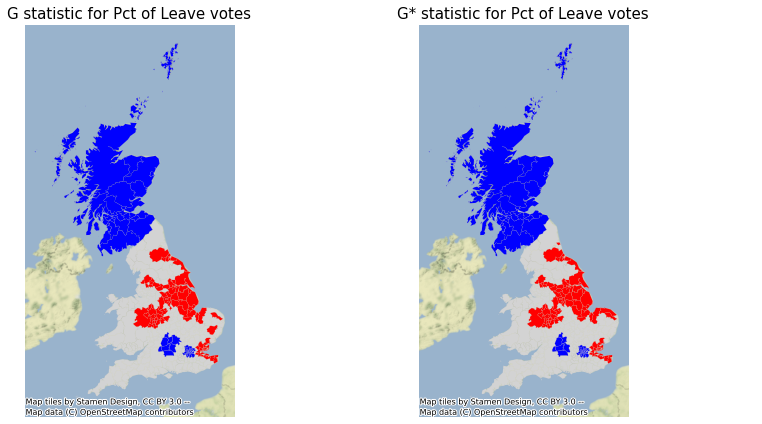

In [25]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics and generate the map
for g, ax in zip([gostats, gostars], axs.flatten()):
    ax = g_map(g, db, ax)
f.tight_layout()
# Render
plt.show()

As you can see, the results are virtually the same for $G_i$ and $G_i^*$. Also, at first glance, these maps appear to be visually similar to the final LISA map from above. Naturally, this leads to the question: *why use the $G$ statistics at all?* The answer to this question is that the two sets of local statistics, local $I$ and the local $G$, are complementary statistics. The local $I$ statistic (on its own) gives an indication of cluster/outlier status, and the local $G$ shows which side of the hotspot/coldspot divide the observation is on. Alternatively, the local Moran's $I_i$ cluster map provides both pieces of information, but can be more challenging to visualize all at once. Thus, it depends on your analytical preferences and the point of the analysis at hand. 

## Conclusion

Local statistics are one of the most commonly-used tools in the geographic data science toolkit. When used properly, local statistics provide a powerful way to analyze and visualize the structure of geographic data. The Local Moran's $I_i$ statistic, as Local Indicator of Spatial Association, summarizes the co-variation between observations and their immediate surroundings. The Getis-Ord local $G$ statistics, on the other hand, compare the sum of values in the area around each site. Regardless, learning to use local statistics effectively is important for any geographic data scientist, as they are the most common "first brush" geographic statistic for many analyses. 

## Questions

1. Do the same Local Moran analysis done for `Pct_Leave`, but using `Pct_Turnout`. Is there a geography to how involved people were in different places? Where was turnout percentage (relatively) higher or lower? 
2. Do the same Getis-Ord analysis done for `Pct_Leave`, but using `Pct_Turnout`. 
3. Local Moran statistics are premised on a few distributional assumptions. One well-recognized concern with Moran statistics is when they are estimated for *rates*. Rate data is distinct from other kinds of data because it embeds the relationship between two quantities: the event and the population. For instance, in the case of Leave voting, the "event" is a person voting leave, and the "population" could be the number of eligible voters, the number of votes cast, or the total number of people. This usually only poses a problem for analysis when the event outcome is somehow dependent on the population. 
    1. Using our past analytical steps, build a new `db` dataframe from `ref` and `lads` that contains the `Electorate`, `Votes_Cast`, and `Leave` columns. 
    - From this new dataframe, make scatterplots of:
       - the number of votes cast and the percent leave vote
       - the size of the electorate and the percent of leave vote
    2. Based on your answers to the previous point, does it appear that there is a relationship between the event and the population size? Use `scipy.stats.kendalltau` or `scipy.stats.pearsonr`  to confirm your visual intuition. 
    3. Using `esda.moran.Moran_Rate`, estimate a global Moran's I that takes into account the rate structure of `Pct_Leave`, using the `Electorate` as the population. Is this estimate different from the one obtained without taking into account the rate structure? What about when `Votes_Cast` is used for the population? 
    4. Using `esda.moran.Moran_Local_Rate`, estimate *local* Moran's I treating Leave data as a rate.
        - does any site's local I change? Make a scatterplot of the `lisa.Is` you estimated before and this new rate-based local Moran. 
        - does any site's local I change their outlier/statistical significance classifications? Use `pandas.crosstab` to examine how many classifications change between the two kinds of statistic. Make sure to consider observations' statistical significances in addition to their quadrant classification.
    5. Make two maps, side by side, of the local statistics without rate correction and with rate correction. Does your interpretation of the maps change depending on the correction?
4. Local statistics use *permutation-based* inference for their significance testing. This means that, to test the statistical significance of a local relationship, values of the observed variable are *shuffled* around the map. These large numbers of *random* maps are then used to compare against the observed map. Local inference requires some restrictions on how each shuffle occurs, since each observation must be "fixed" and compared to randomly-shuffle neighboring observations. The distribution of local statistics for each "shuffle" is contained in the `.rlisas` attribute of a Local Moran object. 
    - For the first observation, make a `seaborn.distplot` of its shuffled local statistics. Add a vertical line to the histogram using `plt.axvline()`. 
    - Do the same for the last observation as well. 
    - Looking only at their permutation distributions, do you expect the first LISA statistic to be statistically-significant? Do you expect the last?
5. LISAs have some amount of fundamental uncertainty due to their estimation. This is called the `standard error` of the statistic.
    - The standard errors are contained in the `.seI_sim` attribute. Make a map of the standard errors. Are there any areas of the map that appear to be more uncertain about their local statistics? 
    - compute the standard deviation of each observation's "shuffle" distribution, contained in the `.rlisas` attribute. Verify that the standard deviation of this shuffle distribution is the same as the standard errors in `seI_sim`. 
6. Local Getis-Ord statistics come in two forms. As discussed above, Getis-Ord $G_i$ statistics *omit* each site from their own local statistic. In contrast, $G_i^*$ statistics *include* the site in its own local statistic.
    - Make a scatterplot of the two types of statistic, contained in `gostats.Zs` and `gostars.Zs` to examine how similar the two forms of the Getis-Ord statistic are. 
    - The two forms of the Getis-Ord statistic differ by their inclusion of the *site* value, $y_i$, in the value for the $G_i$ statistic at that site. So, make a scatterplot of the percent leave variable and the *difference* of the two statistics. Is there a relationship between the percent leave vote and the difference in the two forms of the Getis-Ord statistic? Confirm this for yourself using `scipy.stats.kendalltau` or `scipy.stats.pearsonr`. 